In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../..'))) # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_diffusion, evidence_meta_diffusion
from src.python.helpers import load_empirical_rt_data, join_and_fill_missings
from src.python.helpers import inspect_robustness_noise, inspect_robustness_bootstrap, inspect_robustness_lopo
from src.python.networks import HierarchicalInvariantNetwork, EvidentialNetwork
from src.python.visualization import plot_model_posteriors, plot_noise_robustness

import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.facecolor'] = 'w'

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer 
from bayesflow.losses import log_loss

In [2]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created 
_ = plt.figure()
plt.rcParams['figure.facecolor'] = 'w'

<Figure size 432x288 with 0 Axes>

# Application to empirical data

## Load in data

In [3]:
# Load data from folders

parent_folder = os.path.dirname(os.path.dirname(os.getcwd()))
color_folder = os.path.join(parent_folder, 'data\\03_levy_flight_application\\data_rts\\color')
lexical_folder = os.path.join(parent_folder, 'data\\03_levy_flight_application\\data_rts\\lexical')

color_data = load_empirical_rt_data(color_folder)
lexical_data = load_empirical_rt_data(lexical_folder)

# Join experimental data and fill missing values
empirical_data = join_and_fill_missings(color_data, lexical_data, n_trials=900, missing_rts_equal_mean=True)

## Load in trained network

In [4]:
summary_net = HierarchicalInvariantNetwork(summary_meta_diffusion)
evidence_net = EvidentialNetwork(evidence_meta_diffusion)
amortizer = MultiModelAmortizer(evidence_net, summary_net)

# Checkpoint path for loading pretrained network and saving the final network
checkpoint_path = "c:\\Users\\lasse\\documents\\hierarchical model comparison project\\checkpoints\\03_levy_flight_application\\uniform_alpha_prior\\fine-tuned_net"

trainer = ModelComparisonTrainer(
    network=amortizer, 
    loss=partial(log_loss, kl_weight=0),
    optimizer=partial(Adam),
    checkpoint_path=checkpoint_path,
    skip_checks=True
    )

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from c:\Users\lasse\documents\hierarchical model comparison project\checkpoints\03_levy_flight_application\uniform_alpha_prior\fine-tuned_net\ckpt-96


## Predict

In [5]:
preds = evidence_net.predict(summary_net(empirical_data))
preds

{'m_probs': array([[0.01134788, 0.01134788, 0.01134788, 0.96595633]], dtype=float32),
 'm_var': array([[0.00012588, 0.00012588, 0.00012588, 0.00036898]], dtype=float32),
 'uncertainty': array([[0.04539153]], dtype=float32)}

In [6]:
labels_verbose = ['Basic diffusion model',
                  'Basic Lévy flight model',
                  'Full diffusion model',
                  'Full Lévy flight model']

labels = ['$\mathcal{M}_1$',
          '$\mathcal{M}_2$',
          '$\mathcal{M}_3$',
          '$\mathcal{M}_4$']

### Plot model posteriors

In [7]:
# Get samples from dirichlet distribution
dirichlet = evidence_net.sample(summary_net(empirical_data),100000)
dirichlet_flat = np.squeeze(dirichlet)

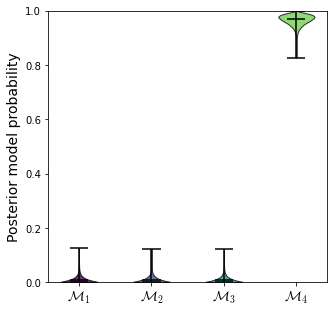

In [8]:
# Plot model posterior 
plot_model_posteriors(dirichlet_samples=dirichlet, labels=labels, save=True)

### Get PMP & BF tables

In [9]:
# Get posterior model probabilities

pmp_table = pd.DataFrame(preds['m_probs'], index=['PMP'], columns=labels)
pmp_table

,$\mathcal{M}_1$,$\mathcal{M}_2$,$\mathcal{M}_3$,$\mathcal{M}_4$
PMP,0.011348,0.011348,0.011348,0.965956


In [10]:
# Get 95% credible interval for posterior model probabilities
cred_pmps = np.quantile(dirichlet_flat, [0.025, 0.975], axis=0).round(2)
cred_pmps

array([[0.  , 0.  , 0.  , 0.92],
       [0.04, 0.04, 0.04, 0.99]])

In [11]:
# Get Bayes Factors

bfs = []

for model in range(4):
    for model_prob in preds['m_probs']:
        model_bfs = model_prob/preds['m_probs'][0][model]
        bfs.append(model_bfs.round(2))

bf_table_all = pd.DataFrame(bfs, index=labels_verbose, columns=labels_verbose)
bf_table_all

,Basic diffusion model,Basic Lévy flight model,Full diffusion model,Full Lévy flight model
Basic diffusion model,1.00,1.00,1.00,85.120003
Basic Lévy flight model,1.00,1.00,1.00,85.120003
Full diffusion model,1.00,1.00,1.00,85.120003
Full Lévy flight model,0.01,0.01,0.01,1.000000


In [17]:
# Select Bayes Factors for publication

bf_table = pd.DataFrame(bf_table_all.iloc[3, :].values.reshape(1, 4), index=['BF'], columns=labels)
bf_table

,$\mathcal{M}_1$,$\mathcal{M}_2$,$\mathcal{M}_3$,$\mathcal{M}_4$
BF,0.01,0.01,0.01,1.0


In [18]:
# Get 95% credible interval for Bayes factors
dirichlet_pref_model = np.reshape(np.repeat(dirichlet_flat[:,3], 4), (100000, 4))
dirichlet_bfs = dirichlet_flat/dirichlet_pref_model
cred_bfs = np.quantile(dirichlet_bfs, [0.025, 0.975], axis=0).round(2)
cred_bfs

array([[0.  , 0.  , 0.  , 1.  ],
       [0.04, 0.04, 0.04, 1.  ]])

In [19]:
# Create table for publication

# Insert credible intervals
for m in range(4):
    bf_table.iloc[0, m] = f'{bf_table.iloc[0, m]:.3}' + f' ({cred_bfs[0][m]}--{cred_bfs[1][m]})' 
    # :.3 to prevent unrounding of BFs
    pmp_table.iloc[0, m] = f'{pmp_table.iloc[0, m]:.2}' + f' ({cred_pmps[0][m]}--{cred_pmps[1][m]})' 
    
bf_table.iloc[0, 3] = '*' # replace 1s of preferred model
results_table = pd.concat([bf_table, pmp_table])
results_table


,$\mathcal{M}_1$,$\mathcal{M}_2$,$\mathcal{M}_3$,$\mathcal{M}_4$
BF,0.01 (0.0--0.04),0.01 (0.0--0.04),0.01 (0.0--0.04),*
PMP,0. (0.0--0.04),0. (0.0--0.04),0. (0.0--0.04),0. (0.92--0.99)


In [15]:
# Get LaTeX table for publication
print(results_table.style.to_latex(position='h', position_float='centering', hrules=True))

\begin{table}[h]
\centering
\begin{tabular}{lllll}
\toprule
 & $\mathcal{M}_1$ & $\mathcal{M}_2$ & $\mathcal{M}_3$ & $\mathcal{M}_4$ \\
\midrule
BF & 1.0 (0.02--39.76) & 1.0 (0.03--40.33) & * & 1.36e+02 (36.0--5303.38) \\
PMP & 0.0072 (0.0--0.03) & 0.0072 (0.0--0.03) & 0.0072 (0.0--0.03) & 0.98 (0.95--1.0) \\
\bottomrule
\end{tabular}
\end{table}



# Robustness checks

## Additional noise

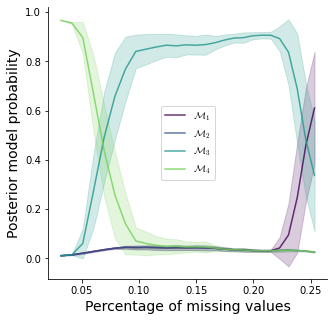

In [10]:
added_noise_percentages = np.arange(0, 0.27, 0.01)
mean_noise_proportion_list, mean_probs, mean_sds, mean_vars = inspect_robustness_noise(added_noise_percentages, 
                                                                                       empirical_data, evidence_net, 
                                                                                       summary_net, n_runs=100)

plot_noise_robustness(mean_noise_proportion_list, mean_probs, mean_sds, labels, save=True)

## Resampled trials within participants

In [11]:
bootstrapped_trials = inspect_robustness_bootstrap(empirical_data, evidence_net, summary_net, level='trials')
bootstrapped_participants = inspect_robustness_bootstrap(empirical_data, evidence_net, summary_net, level='participants')
leave_one_participant_out = inspect_robustness_lopo(empirical_data, evidence_net, summary_net)

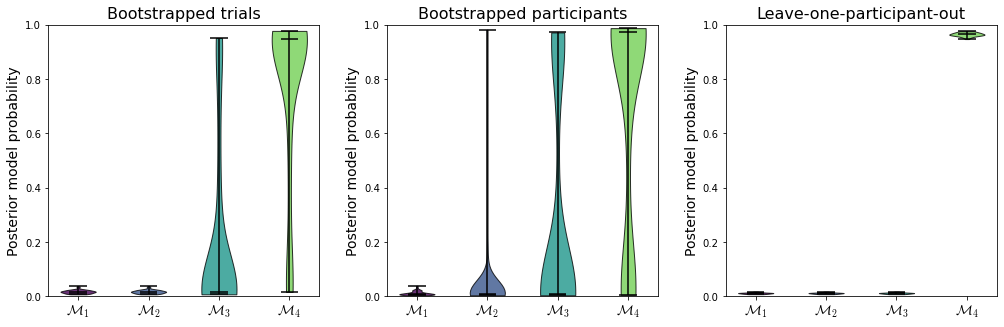

In [12]:
fig, axarr = plt.subplots(1, 3, figsize=(17, 5))
plt.subplots_adjust(wspace=0.25)

plot_model_posteriors(bootstrapped_trials, labels, title='Bootstrapped trials', ax=axarr[0])
plot_model_posteriors(bootstrapped_participants, labels, title='Bootstrapped participants',ax=axarr[1])
plot_model_posteriors(leave_one_participant_out, labels, title='Leave-one-participant-out',ax=axarr[2])

plt.savefig('levy_resampling_robustness.png', dpi=300, bbox_inches='tight')

## Selectively mask specific trials

Hypothesis: The superiority of the full levy flight model and the lack of robustness of the results is due to the ability of the levy flight model to explain very fast guesses. Masking the fastest trials as noise should have a major influence on the model comparison results.

In [151]:
from src.python.helpers import mask_inputs, mean_predictions_noisy_data

In [48]:
mean_predictions_noisy_data(empirical_data, evidence_net, summary_net, missings_mean=0, n_runs=100)

(0.03169444444444444,
 array([[0.01134789, 0.01134789, 0.01134789, 0.9659571 ]], dtype=float32),
 array([[0.        , 0.        , 0.        , 0.00000077]], dtype=float32),
 array([[0.00012588, 0.00012588, 0.00012588, 0.00036898]], dtype=float32))

In [146]:
preds_random_masks = mean_predictions_noisy_data(empirical_data, evidence_net, summary_net, missings_mean=25, n_runs=100)
preds_random_masks

(0.05823777777777778,
 array([[0.02679191, 0.02687298, 0.21074833, 0.7355869 ]], dtype=float32),
 array([[0.00236214, 0.00244309, 0.13504153, 0.13927387]], dtype=float32),
 array([[0.00068507, 0.00068722, 0.00400138, 0.00468264]], dtype=float32))

In [150]:
empirical_data[empirical_data[:,:,:,2] == -1]

array([[ 1.        ,  0.55359447, -1.        ],
       [ 0.        ,  0.55359447, -1.        ],
       [ 1.        ,  0.55359447, -1.        ],
       ...,
       [ 1.        ,  0.6160962 , -1.        ],
       [ 1.        ,  0.6160962 , -1.        ],
       [ 1.        ,  0.6160962 , -1.        ]], dtype=float32)

In [158]:
mask_inputs(empirical_data.copy(), 900, 0.1, insert_additional_missings=True)

array([[[[ 1.        ,  0.42      ,  1.        ],
         [ 1.        ,  0.428     ,  1.        ],
         [ 0.        , -0.4231994 , -1.        ],
         ...,
         [ 0.        ,  0.55359447, -1.        ],
         [ 0.        , -0.4231994 , -1.        ],
         [ 0.        , -0.4231994 , -1.        ]],

        [[ 1.        , -0.458549  , -1.        ],
         [ 1.        ,  0.574     ,  1.        ],
         [ 1.        , -0.458549  , -1.        ],
         ...,
         [ 1.        , -0.458549  , -1.        ],
         [ 0.        ,  0.5024844 , -1.        ],
         [ 0.        ,  0.5024844 , -1.        ]],

        [[ 1.        , -0.43638128, -1.        ],
         [ 0.        , -0.43638128, -1.        ],
         [ 1.        ,  0.948     ,  1.        ],
         ...,
         [ 0.        , -0.43638128, -1.        ],
         [ 1.        , -0.43638128, -1.        ],
         [ 0.        , -0.43638128, -1.        ]],

        ...,

        [[ 1.        , -0.42544156, -1

(array([ 115.,  728., 3422., 7409., 8267., 6091., 3794., 2229., 1268.,
         802.]),
 array([0.188     , 0.2691    , 0.3502    , 0.43129998, 0.51240003,
        0.5935    , 0.6746    , 0.7557    , 0.8368    , 0.9179    ,
        0.999     ], dtype=float32),
 <BarContainer object of 10 artists>)

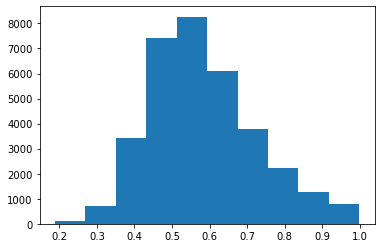

In [41]:
plt.hist(np.ndarray.flatten(empirical_data[:,:,:,1])[np.ndarray.flatten(empirical_data[:,:,:,1])<1.0])

In [147]:
data_fast_masked = empirical_data.copy()

# determine reaction cutoff
cutoff = np.quantile(np.ndarray.flatten(empirical_data[:,:,:,1]), [0.05])[0]

# mask fast decisions as -1
fast_trials = data_fast_masked[:,:,:,1] <= cutoff
data_fast_masked[:,:,:,2][fast_trials] = -1

# replace fast reaction times with person mean
for j in range(40):
    fast_trials_j = data_fast_masked[:,j,:,1] <= cutoff
    if np.sum(fast_trials_j) > 0:
        print(j, np.sum(fast_trials_j))
    data_fast_masked[:,j,:,1][fast_trials_j] = np.mean(data_fast_masked[:,j,:,1])

0 125
1 113
2 8
4 137
5 2
6 46
7 12
8 69
9 16
10 347
11 36
12 2
13 1
14 13
15 32
16 48
17 18
18 42
19 67
20 3
21 50
22 179
23 178
25 59
26 18
27 2
28 12
29 15
31 76
32 7
33 29
34 11
35 27
38 55
39 13


In [148]:
# check percentual amount of missing data
(data_fast_masked[:,:,:,2] == -1).sum()/(40*900)

0.08358333333333333

In [159]:
data_fast_masked[fast_trials]

array([[ 1.        ,  0.55359447, -1.        ],
       [ 0.        ,  0.55359447, -1.        ],
       [ 0.        ,  0.55359447, -1.        ],
       ...,
       [ 0.        ,  0.61609626, -1.        ],
       [ 1.        ,  0.61609626, -1.        ],
       [ 1.        ,  0.61609626, -1.        ]], dtype=float32)

In [160]:
empirical_data[fast_trials]

array([[1.   , 0.372, 1.   ],
       [0.   , 0.38 , 1.   ],
       [0.   , 0.373, 1.   ],
       ...,
       [0.   , 0.365, 0.   ],
       [1.   , 0.388, 1.   ],
       [1.   , 0.388, 1.   ]], dtype=float32)

In [149]:
evidence_net.predict(summary_net(data_fast_masked))

{'m_probs': array([[0.01174607, 0.01174607, 0.01174607, 0.9647618 ]], dtype=float32),
 'm_var': array([[0.00013477, 0.00013477, 0.00013477, 0.00039469]], dtype=float32),
 'uncertainty': array([[0.04698426]], dtype=float32)}